In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\hovsep.avagyan\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\hovsep.avagyan\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Data preprocessing

In [2]:
df = pd.read_csv('May_promo.txt',sep='\t', names=["Date", "Users", "BetAmount"], parse_dates=True).sort_values(by='Date').reset_index(drop=True)
df.head()

,Date,Users,BetAmount
0,2021-09-01,506534,14600.000
1,2021-09-01,497956,2700.000
2,2021-09-01,733225,1400.000
3,2021-09-01,190520,1537860.000
4,2021-09-01,167771,19725.000


In [3]:
# chage format of Date column
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [4]:
# Functions to distribute points based on the BetAmount of User

def calculate_points100(df):
    count=0
    amount = df["BetAmount"]
    if amount>=25000:
        count = amount//25000+3
    elif amount>=10000:
        count = 3
    elif amount>=5000:
        count = 2 
    elif amount>=1000:
        count = 1
    return count    

#The functions below may be needed for further calculations(in different cases we may not use them)

# def calculate_points500(df):
#     count=0
#     amount = df["BetAmounts"]
#     if amount>=100000:
#         count = amount//100000+3
#     elif amount>=50000:
#         count = 3
#     elif amount>=25000:
#         count = 2 
#     elif amount>=10000:
#         count = 1
#     return count    

# def calculate_points1000(df):
#     count=0
#     amount = df["BetAmounts"]
#     if amount>=200000:
#         count = amount//200000+3
#     elif amount>=100000:
#         count = 3
#     elif amount>=50000:
#         count = 2 
#     elif amount>=25000:
#         count = 1
#     return count    


In [5]:
df.drop('Users',axis = 1,inplace = True)
df = df.set_index('Date')
df.head()

,BetAmount
Date,
2021-09-01,14600.000
2021-09-01,2700.000
2021-09-01,1400.000
2021-09-01,1537860.000
2021-09-01,19725.000


In [6]:
new_df = df.groupby(['Date']).agg({'BetAmount':sum})
new_df.head()

,BetAmount
Date,
2021-09-01,2542060258.870
2021-09-02,2640599767.035
2021-09-03,2963298574.390
2021-09-04,2974584935.565
2021-09-05,2412061086.440


In [7]:
# Explore some values that may be potential outliars
new_df_mins = new_df[new_df['BetAmount'] <= 2500000000]
new_df_mins

,BetAmount
Date,
2021-09-05,2412061086.440
2021-09-09,2497119609.180
2021-09-13,2479635786.050
2021-09-19,2391512993.968
2021-09-21,2160769407.920
2021-09-26,2242815246.180
2021-10-03,2449749554.970
2021-10-10,2489352709.860
2021-10-13,2497141609.360


### Some Visualizations

In [8]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {} \n {}".format(window,series.columns[0]))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series.iloc[window:], rolling_mean[window:])
        deviation = np.std(series.iloc[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


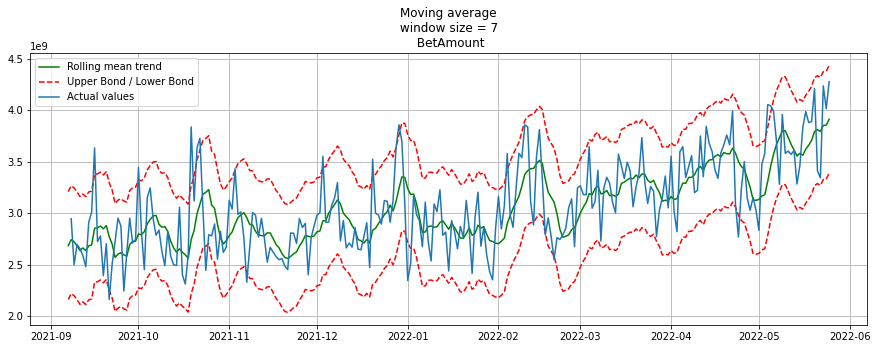

In [9]:
plotMovingAverage(new_df, 7, True,True)

In [10]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
# activate if needed
#     if not isinstance(y, pd.Series):
#         y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

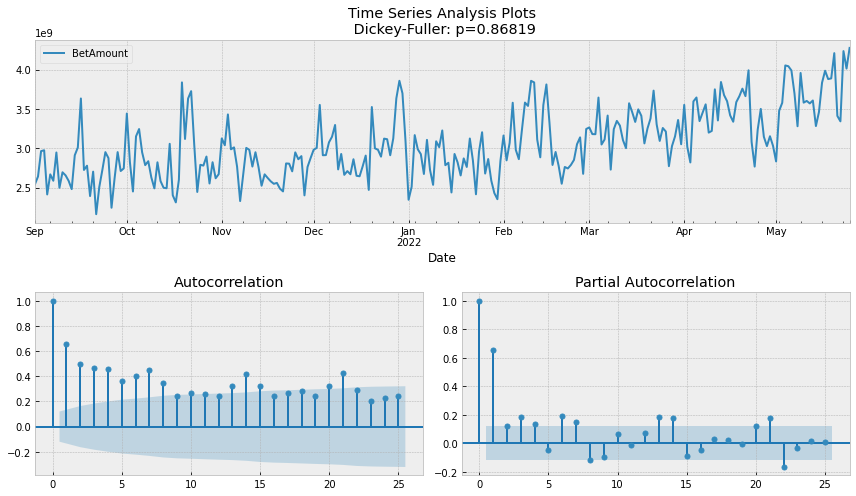

In [11]:
# See data lags and Dickey-Fuller test
tsplot(new_df, lags = 25)

### Predicting for the next cycle

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)

# Season
s = 35

# Create all possible permutations 
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [14]:
def optimizeSARIMA(parameters_list, d, D, s,df):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [15]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s,new_df)
result_table.head()


  0%|          | 0/36 [00:00<?, ?it/s]

Wall time: 3min 20s


,parameters,aic
0,"(2, 4, 0, 1)",9670.875
1,"(3, 4, 0, 1)",9672.136
2,"(2, 4, 1, 1)",9672.876
3,"(3, 4, 1, 1)",9674.033
4,"(2, 2, 0, 1)",9675.722


In [16]:
# Getting final parameter list
p, q, P, Q = result_table.parameters[0]

In [17]:
best_model=sm.tsa.statespace.SARIMAX(new_df, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            BetAmount   No. Observations:                  267
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 35)   Log Likelihood               -4827.438
Date:                              Thu, 21 Jul 2022   AIC                           9670.875
Time:                                      15:55:41   BIC                           9698.415
Sample:                                  09-01-2021   HQIC                          9681.983
                                       - 05-25-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6675      0.132    -12.634      0.000      -1.926      -1.409
ar.L2         -0.84

In [18]:
def predSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    forecasted  = []
    forecasted.append(forecast)
    return forecasted

In [19]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

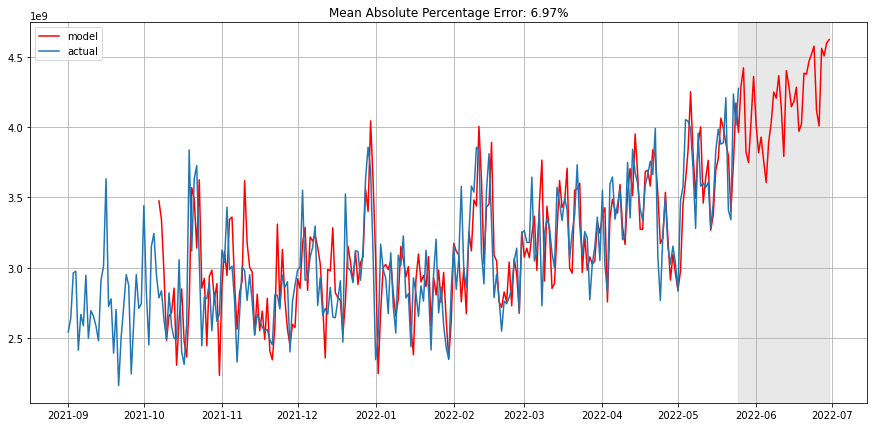

In [20]:
plotSARIMA(new_df, best_model,35)

In [21]:
pred = predSARIMA(new_df, best_model,35)[0].to_frame('BetAmount')
pred

,BetAmount
2021-09-01,NaN
2021-09-02,NaN
2021-09-03,NaN
2021-09-04,NaN
2021-09-05,NaN
...,...
2022-06-26,4009020084.294
2022-06-27,4561288363.064
2022-06-28,4508389371.013
2022-06-29,4599876235.923


In [22]:
# only predictions that do not have an actual value
predicted = pred[-36:-1]

In [23]:
# import to excel the last season prediction or All, just choose which one to run
# pred.to_excel('FILE_NAME.xlsx')
# predicted.to_excel('FILE_NAME.xlsx')

### Find percentage raise and apply to each user

In [24]:
def calculate_prct_growth(pred,actual):
    return pred.sum()/actual.sum()

In [25]:
prc_change = calculate_prct_growth(predicted,new_df[-35:])

In [26]:
# opening same data just to not confuse and change anything from the original one
my_df = pd.read_csv('May_promo.txt',sep='\t', names=["Date", "Users", "BetAmount"], parse_dates=True).sort_values(by='Date').reset_index(drop=True)

my_df['Date'] = pd.to_datetime(my_df['Date'], format='%Y-%m-%d')
my_df = my_df.set_index('Date')
my_df.head()

,Users,BetAmount
Date,,
2021-09-01,506534,14600.000
2021-09-01,497956,2700.000
2021-09-01,733225,1400.000
2021-09-01,190520,1537860.000
2021-09-01,167771,19725.000


In [27]:
my_df = my_df.groupby(['Users','Date']).agg({'BetAmount':sum})
my_df.reset_index(inplace = True)
my_df.head()

,Users,Date,BetAmount
0,131225,2021-09-03,26400.000
1,131225,2021-09-04,60050.000
2,131225,2021-09-10,18300.000
3,131225,2021-09-11,1100.000
4,131225,2021-10-11,4200.000


In [28]:
# apply the percentage change to the column
my_df['BetAmount'] = my_df['BetAmount']*prc_change[0]

In [29]:
# Distribute points to users
my_df["Points100"]= my_df.apply(calculate_points100, axis=1).astype(int)
my_df.head()

,Users,Date,BetAmount,Points100
0,131225,2021-09-03,30654.042,4
1,131225,2021-09-04,69726.334,5
2,131225,2021-09-10,21248.825,3
3,131225,2021-09-11,1277.252,1
4,131225,2021-10-11,4876.779,1


In [30]:
# Get the Daily amount of the points/ you can manipulate it to calculate whatever is needed
my_df = my_df.set_index('Date')
my_df = my_df.groupby(['Date']).agg({'Points100':sum,'BetAmount':sum, 'Users':'count'})

my_df.head()

,Points100,BetAmount,Users
Date,,,
2021-09-01,145518,2951682654.684,16648
2021-09-02,149693,3066100617.845,15369
2021-09-03,169110,3440798451.633,17344
2021-09-04,165318,3453903473.986,14853
2021-09-05,137776,2800735681.242,14147


In [31]:
# my_df[-35:].to_excel('FILE_NAME.xlsx')